# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(0, os.environ.get('SRC_FIGMA_PATH'))


from cryptocurrencyetl import CryptocurrencyEtl
import context as c
from dataanalysis import DataAnalysis

# 1.0. Data Extraction

In [2]:
# crypto = 'BTC'
# market_curr = 'USD'
# api_key = os.environ.get('TOKEN_FIGMA_CRYPTO_KEY')

# crypt_etl = CryptocurrencyEtl(crypto=crypto, market_curr=market_curr, api_key=api_key)

# #crypt_etl.test_market_curr()
# #crypt_etl.test_crypto()

# df_btc_usd = crypt_etl.run()

In [3]:
df_btc_usd = pd.read_csv(c.DATA_PROC_FLD / 'btc_usd_proc.csv')

# 2.0. Data Analysis

In [4]:
analy = DataAnalysis(df_btc_usd, date_col='timestamp', individual_figsize=(18, 8))

## 2.1. Statistical Description

In [5]:
analy.statistical_description()

,attributes,mean,median,std,min,max,range,skew,kurtosis
0,open,28562.440940,30306.575000,18631.241868,4800.01000,67525.820000,62725.810000,0.239380,-1.414270
1,high,29360.903560,31394.450000,19149.279388,5365.42000,69000.000000,63634.580000,0.226920,-1.433496
2,low,27646.317530,29288.285000,18023.135373,3782.13000,66222.400000,62440.270000,0.253444,-1.393578
3,close,28575.082040,30306.585000,18623.211023,4800.00000,67525.830000,62725.830000,0.238616,-1.413078
4,volume,65094.226786,55546.057727,38507.500476,3139.84807,402201.673764,399061.825694,2.609826,12.181748


## 2.2. Temporal Estability

/home/valcilio/all_proj/proj_figma/src/dataanalysis.py:166: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels('xtick', rotation=70)
/home/valcilio/all_proj/proj_figma/src/dataanalysis.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels('xtick', rotation=70)


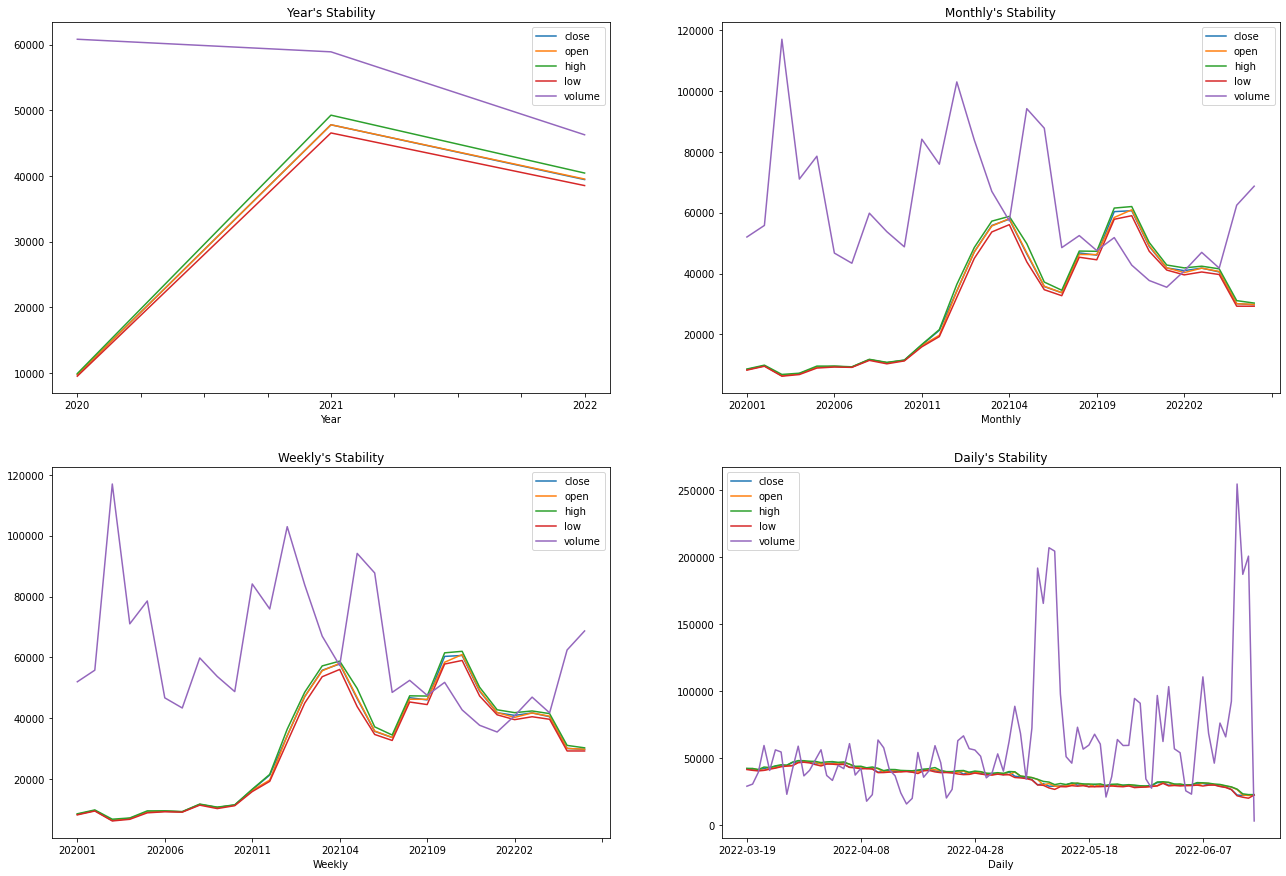

In [6]:
analy.all_timely_stability(y=['close', 'open', 'high', 'low', 'volume'])

## 2.3. Outlier Identification

/home/valcilio/all_proj/proj_figma/src/dataanalysis.py:202: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels('xtick', rotation=70)


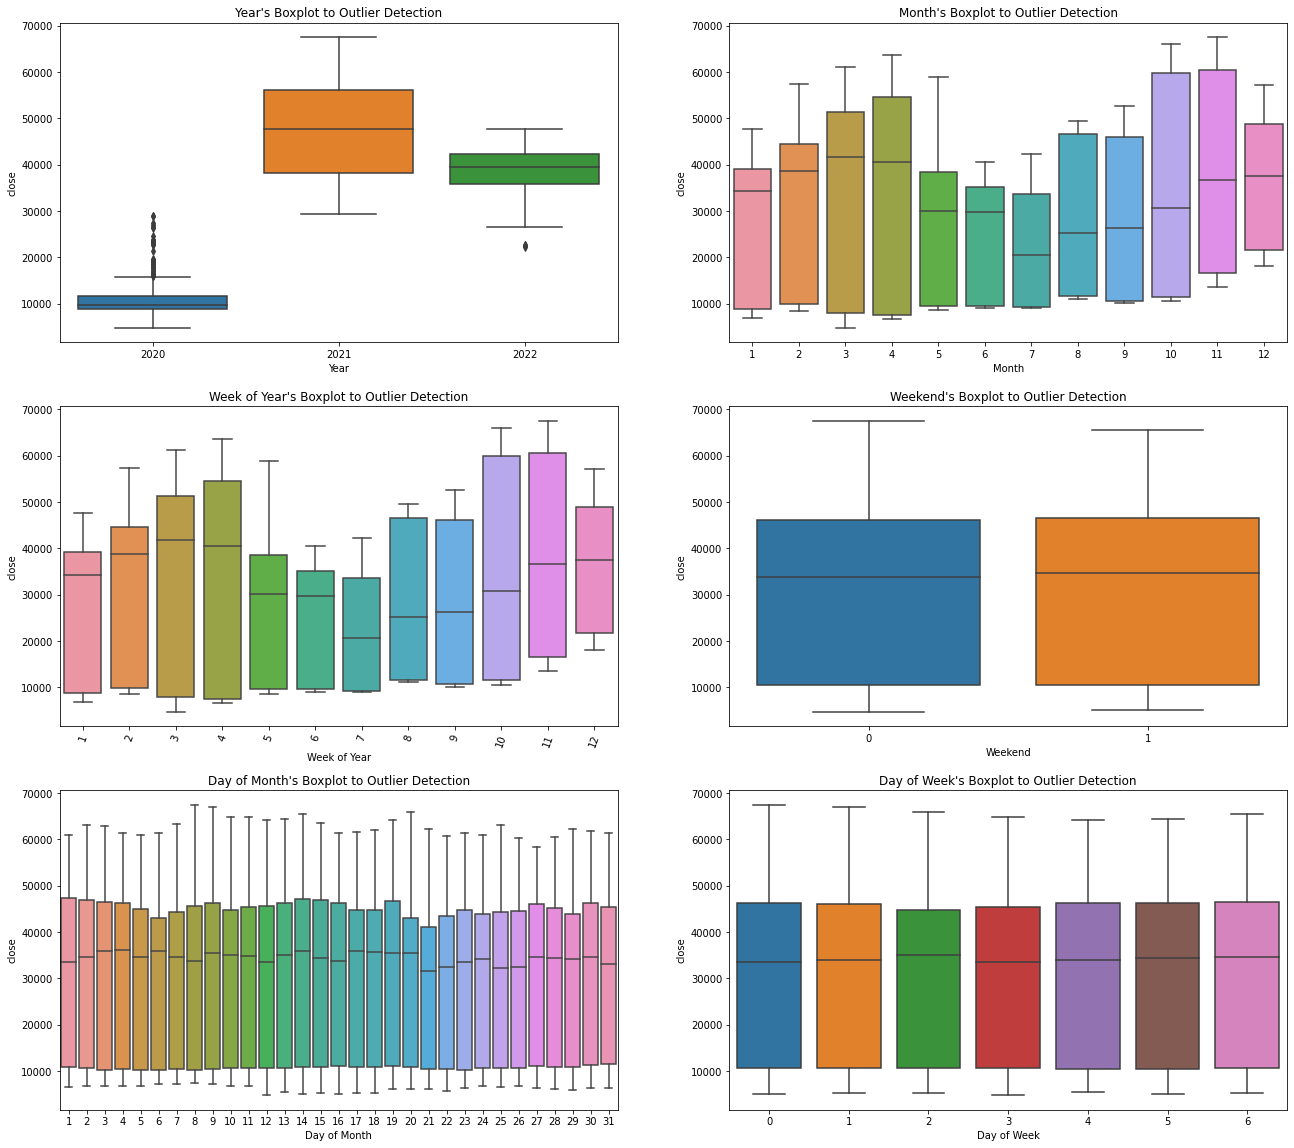

In [7]:
analy.all_temporal_outlier_detector_boxplots()

## 2.4. Distribution

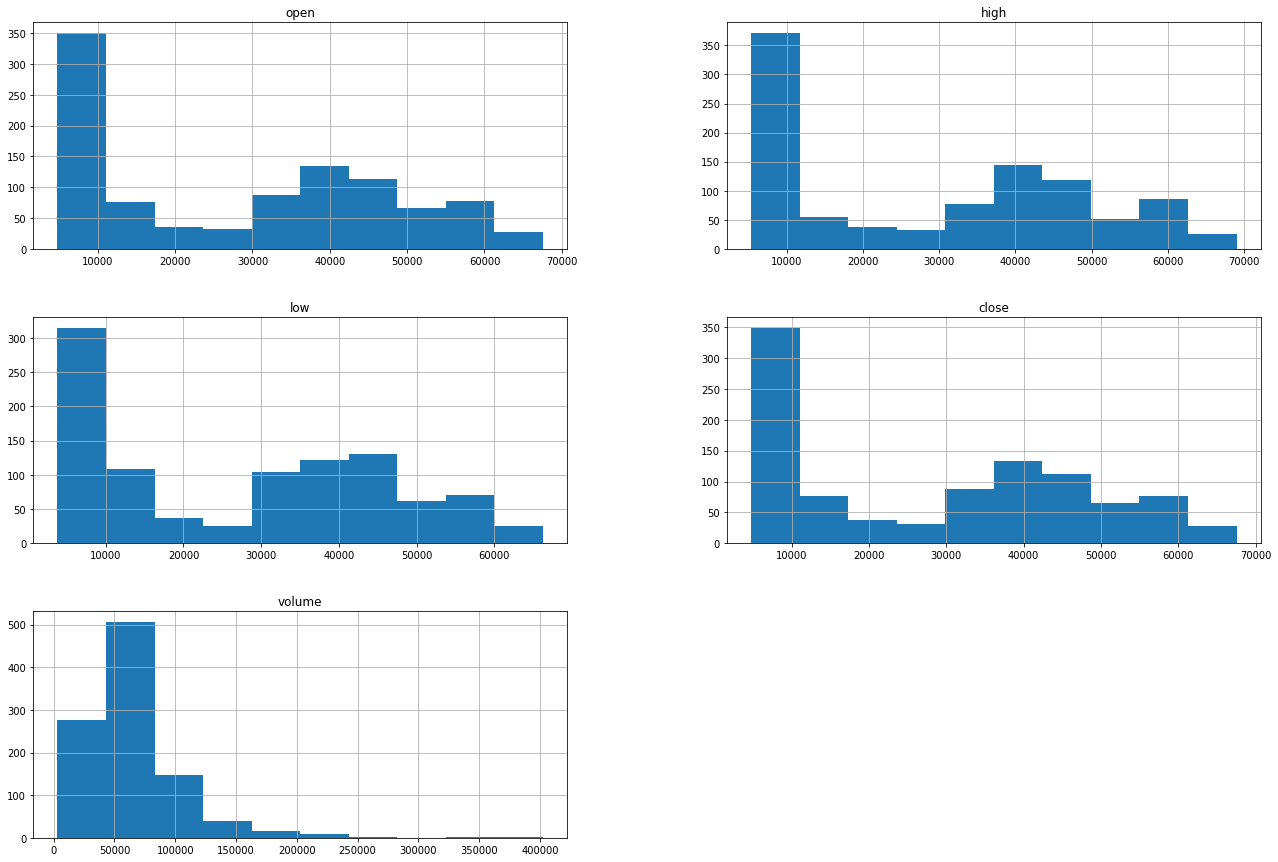

In [8]:
analy.distribution_check()

## 2.5. Nature Transformation Effect

In [13]:
np.log(df_btc_usd['close'])

0       9.208978
1       9.213223
2       9.180113
3       9.047014
4       9.039558
         ...    
995    10.187709
996    10.020711
997    10.004979
998    10.024985
999    10.028553
Name: close, Length: 1000, dtype: float64

<AxesSubplot:>

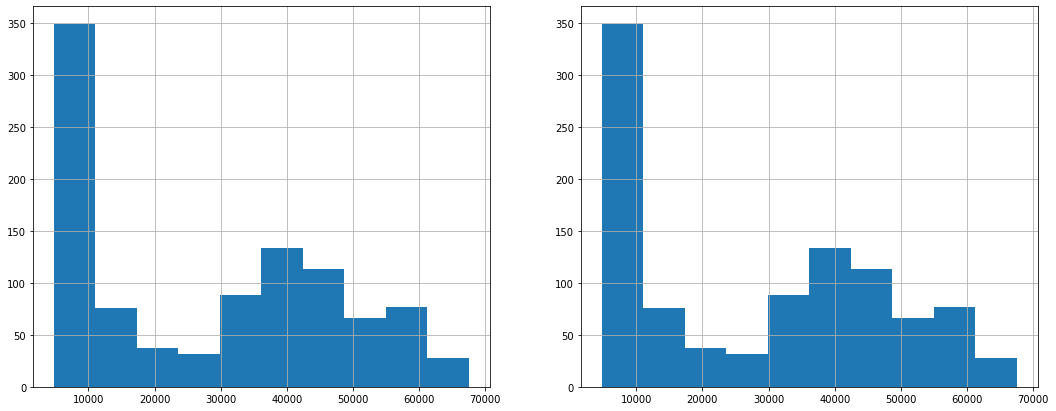

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7));
df_btc_usd['close'].hist(ax=ax1)
df_btc_usd['close'].hist(ax=ax2)

# 3.0. Data Preparation

## 3.1. Adjust Dataset

## 3.2. Nature Transformation

# 4.0. Machine Learning Model

## 4.1. SARIMAX

### 4.1.1. Modeling

### 4.1.2. Validation

## 4.2. ARIMA

### 4.2.1. Modeling

### 4.2.2. Validation

## 4.3. Saving Model